# Install

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os
import wandb
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchinfo import summary
import torch.nn.functional as F
import timm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!wandb login 'c46e89226ccd773f7fcb283fb6c2e784391a5c13'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
!nvidia-smi

Sun Nov 24 15:01:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [5]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)
        
len(image_path)

1000

In [6]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
        
len(mask_path)

1000

In [7]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

# Model

## Blocks

In [13]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        se = F.adaptive_avg_pool2d(x, 1).view(b, c)
        se = F.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se)).view(b, c, 1, 1)
        return x * se


class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super().__init__()
        
        # Channel Attention Module
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Avg Pooling
            nn.AdaptiveMaxPool2d(1),  # Global Max Pooling
            nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Channel Attention
        avg_out = self.channel_attention[0](x)
        max_out = self.channel_attention[1](x)
        avg_out = self.channel_attention[2:](avg_out)
        max_out = self.channel_attention[2:](max_out)
        channel_attention = avg_out + max_out
        x = x * channel_attention  # Element-wise multiplication
        
        # Spatial Attention
        avg_pool = torch.mean(x, dim=1, keepdim=True)  # Channel Avg Pooling
        max_pool, _ = torch.max(x, dim=1, keepdim=True)  # Channel Max Pooling
        spatial_attention = self.spatial_attention(torch.cat([avg_pool, max_pool], dim=1))
        x = x * spatial_attention  # Element-wise multiplication
        
        return x


class ASPP(nn.Module):
    def __init__(self, in_c, out_c, rate=[1, 6, 12, 18]):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[0], padding=rate[0]),
            nn.BatchNorm2d(out_c)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[1], padding=rate[1]),
            nn.BatchNorm2d(out_c)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[2], padding=rate[2]),
            nn.BatchNorm2d(out_c)
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[3], padding=rate[3]),
            nn.BatchNorm2d(out_c)
        )

        self.c5 = nn.Conv2d(out_c, out_c, kernel_size=1, padding=0)

    def forward(self, inputs):
        x1 = self.c1(inputs)
        x2 = self.c2(inputs)
        x3 = self.c3(inputs)
        x4 = self.c4(inputs)
        x = x1 + x2 + x3 + x4
        y = self.c5(x)
        return y


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction=reduction)
        self.cbam = CBAM(out_channels, reduction=reduction)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam(x)
        return x


## Nested UNet

In [14]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return out


class NestedUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False, **kwargs):
        super().__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]

        else:
            output = self.final(x0_4)
            return output

## ResNet UNet

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        # self.bn3 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        # x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)


class ResNetEncoder(nn.Module):
    def __init__(self, block, num_blocks):
        super().__init__()
        self.in_channels = 3

        # Initial Convolution and Pooling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.cbam1 = CBAM(64, reduction=16)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.cbam2 = CBAM(128, reduction=16)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.cbam3 = CBAM(256, reduction=16)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.cbam4 = CBAM(512, reduction=16)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1_p = self.pool(x)

        x2 = self.layer1(x1_p)
        x2 = self.cbam1(x2)
        
        x3 = self.layer2(x2)
        x3 = self.cbam2(x3)
        
        x4 = self.layer3(x3)
        x4 = self.cbam3(x4)
        
        x5 = self.layer4(x4)
        x5 = self.cbam4(x5)

        return x1, x2, x3, x4, x5


In [18]:
class ResNetUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Encoder
        self.encoder = ResNetEncoder(ResidualBlock, [2, 2, 2, 2])

        # Bottleneck
        self.aspp = ASPP(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(512 + 256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(256 + 128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(128 + 64, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(64 + 64, 64)

        # Final layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1, x2, x3, x4, x5 = self.encoder(x)

        # Bottleneck
        b = self.aspp(x5)

        # Decoder
        d4 = self.dec4(torch.cat([self.up4(b), x4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), x3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), x2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2),F.interpolate(x1, size=self.up1(d2).shape[2:], mode='bilinear', align_corners=False)], dim=1))  

        # Final layer
        return self.final(d1)


In [19]:
model = ResNetUNet(num_classes=3)

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
# model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                        Output Shape              Param #
ResNetUNet                                    [1, 3, 256, 256]          --
├─ResNetEncoder: 1-1                          [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─MaxPool2d: 2-3                         [1, 3, 128, 128]          --
│    └─Sequential: 2-4                        [1, 64, 128, 128]         --
│    │    └─ResidualBlock: 3-1                [1, 64, 128, 128]         39,296
│    │    └─ResidualBlock: 3-2                [1, 64, 128, 128]         74,112
│    └─CBAM: 2-5                              [1, 64, 128, 128]         --
│    │    └─Sequential: 3-3                   --                        512
│    │    └─Sequential: 3-4                   [1, 1, 128, 128]          98
│    └─Sequential: 2-6                        [1, 128, 64, 64]          --
│    │ 

# Load data

In [20]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [21]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma(gamma_limit=(70, 130), p=0.4),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


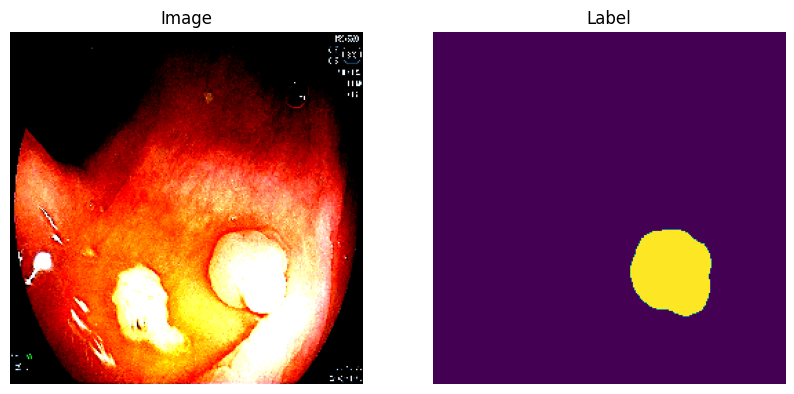

In [22]:
image,label = train_dataset[2]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

In [23]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

# Train

In [24]:
NUM_EPOCHS = 150
LEARNING_RATE = 0.0001

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.NAdam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=0.0001)

CHECKPOINT_PATH = "/kaggle/working/best_model.pth"

In [25]:
def dice_loss(pred, target, epsilon=1e-6):
    # Flatten tensors to calculate overlap
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    # Calculate Dice coefficient
    intersection = (pred * target).sum()
    dice = (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

    return 1 - dice


def dice_loss_with_logits(pred_logits, target, epsilon=1e-6):
    # Apply softmax to get probabilities
    pred_probs = F.softmax(pred_logits, dim=1)

    # One-hot encode target
    target_one_hot = F.one_hot(target, num_classes=pred_probs.shape[1]).permute(0, 3, 1, 2).float()

    # Compute Dice Loss for each class
    dice_loss_sum = 0.0
    for c in range(pred_probs.shape[1]):
        pred_c = pred_probs[:, c, :, :]
        target_c = target_one_hot[:, c, :, :]
        dice_loss_sum += dice_loss(pred_c, target_c, epsilon)

    return dice_loss_sum / pred_probs.shape[1]


def hybrid_loss(pred_logits, target, alpha=0.5, beta=0.5, epsilon=1e-6):
    dice = dice_loss_with_logits(pred_logits, target, epsilon)
    ce = F.cross_entropy(pred_logits, target)
    return alpha * dice + beta * ce


criterion = hybrid_loss

In [26]:
# WandB logging
PROJECT = "UNet Polyp copycat"

wandb.init(
    project=PROJECT,
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        "batch_size": batch_size,
    },
)
wandb.watch(model)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brandonmai (brandonmai-hanoi-university-of-science-and-technology3765). Use `wandb login --relogin` to force relogin


[]

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch [1/150], Loss: 0.6761235136
Save new model


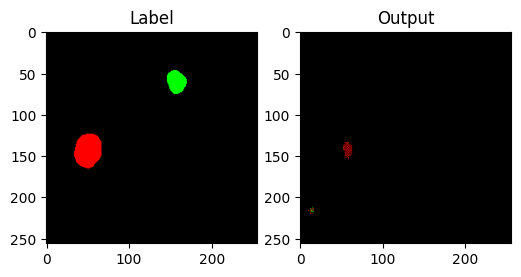

  1%|          | 1/150 [00:36<1:30:05, 36.28s/it]




Epoch [2/150], Loss: 0.5165859598
Save new model


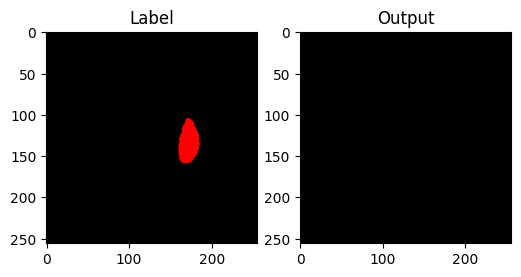

  1%|▏         | 2/150 [01:12<1:29:41, 36.36s/it]




Epoch [3/150], Loss: 0.4502326135
Save new model


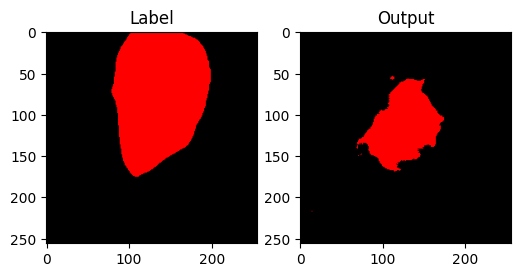

  2%|▏         | 3/150 [01:49<1:29:01, 36.34s/it]




Epoch [4/150], Loss: 0.4186876256
Save new model


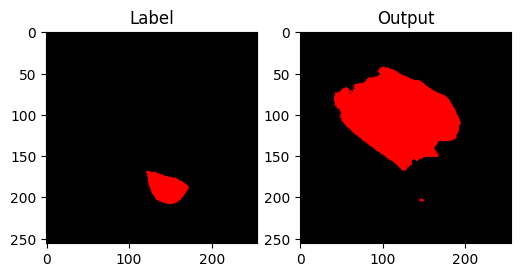

  3%|▎         | 4/150 [02:25<1:28:23, 36.32s/it]




Epoch [5/150], Loss: 0.3961813037
Save new model


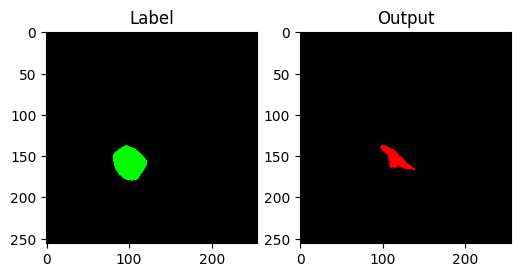

  3%|▎         | 5/150 [03:01<1:27:48, 36.34s/it]




Epoch [6/150], Loss: 0.3577056023
Save new model


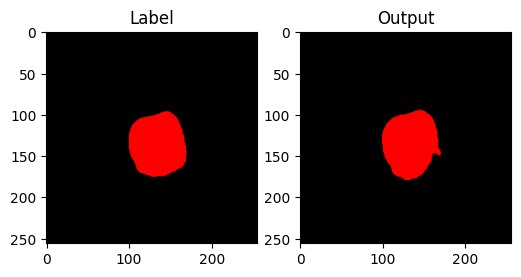

  4%|▍         | 6/150 [03:37<1:27:11, 36.33s/it]




Epoch [7/150], Loss: 0.3608884468


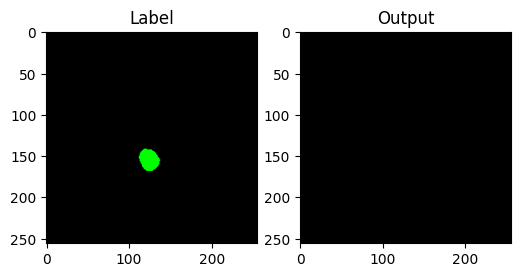

  5%|▍         | 7/150 [04:13<1:25:43, 35.97s/it]




Epoch [8/150], Loss: 0.3574521450
Save new model


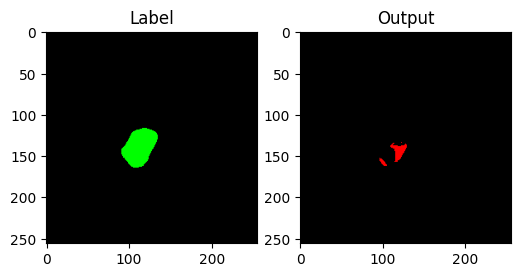

  5%|▌         | 8/150 [04:50<1:25:47, 36.25s/it]




Epoch [9/150], Loss: 0.3485166912
Save new model


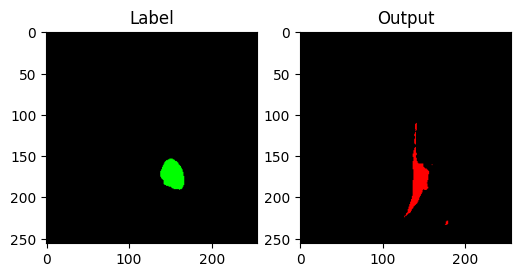

  6%|▌         | 9/150 [05:26<1:25:36, 36.43s/it]




Epoch [10/150], Loss: 0.3328734040
Save new model


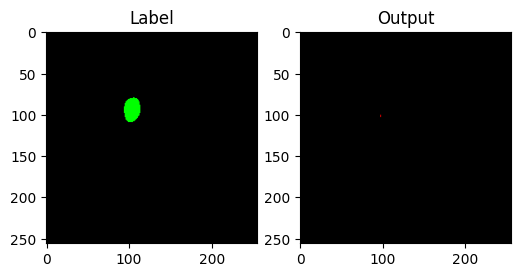

  7%|▋         | 10/150 [06:03<1:25:07, 36.48s/it]




Epoch [11/150], Loss: 0.3395113853


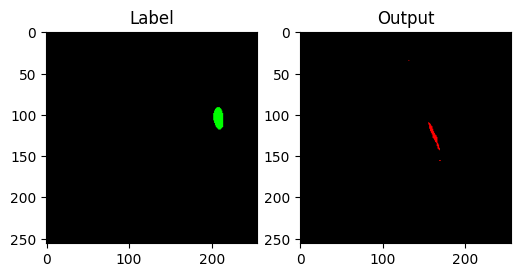

  7%|▋         | 11/150 [06:38<1:23:39, 36.11s/it]




Epoch [12/150], Loss: 0.3214448026
Save new model


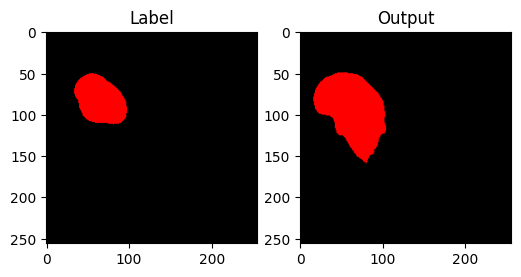

  8%|▊         | 12/150 [07:15<1:23:23, 36.25s/it]




Epoch [13/150], Loss: 0.3146653978
Save new model


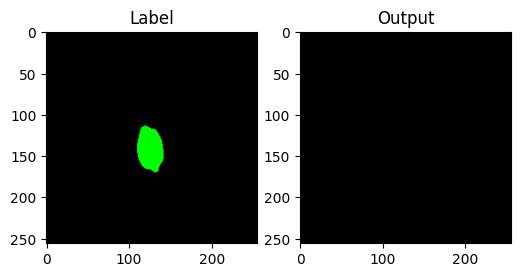

  9%|▊         | 13/150 [07:51<1:23:03, 36.37s/it]




Epoch [14/150], Loss: 0.3061327728
Save new model


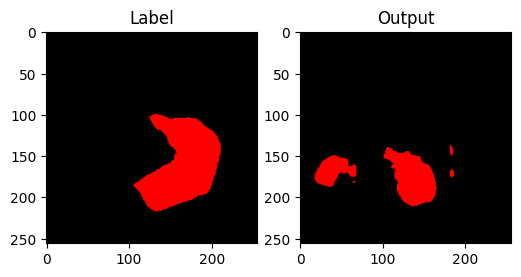

  9%|▉         | 14/150 [08:28<1:22:40, 36.47s/it]




Epoch [15/150], Loss: 0.3185804395


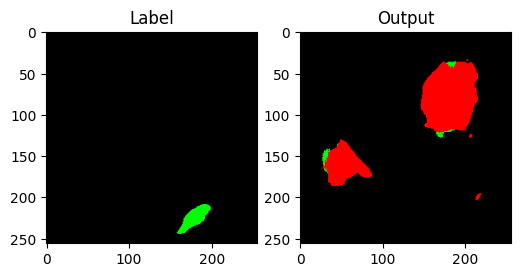

 10%|█         | 15/150 [09:03<1:21:15, 36.12s/it]




Epoch [16/150], Loss: 0.2951876017
Save new model


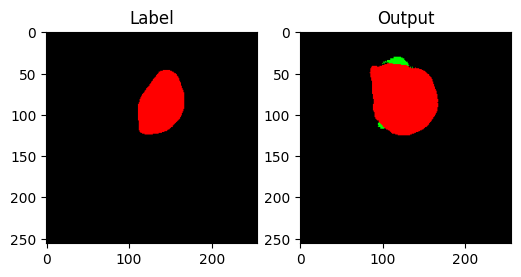

 11%|█         | 16/150 [09:40<1:21:01, 36.28s/it]




Epoch [17/150], Loss: 0.2931060401
Save new model


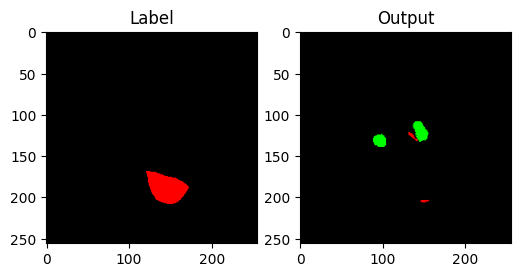

 11%|█▏        | 17/150 [10:17<1:20:38, 36.38s/it]




Epoch [18/150], Loss: 0.2861028382
Save new model


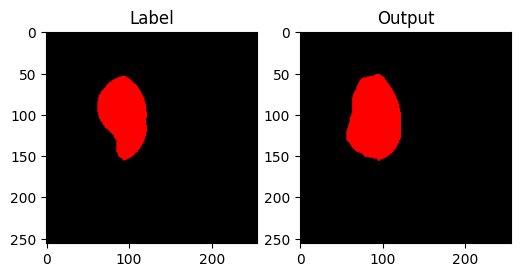

 12%|█▏        | 18/150 [10:54<1:20:19, 36.51s/it]




Epoch [19/150], Loss: 0.2799429767
Save new model


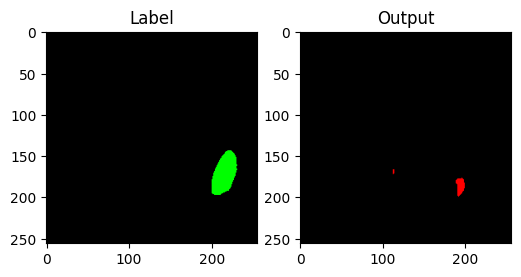

 13%|█▎        | 19/150 [11:30<1:19:46, 36.54s/it]




Epoch [20/150], Loss: 0.2911747396


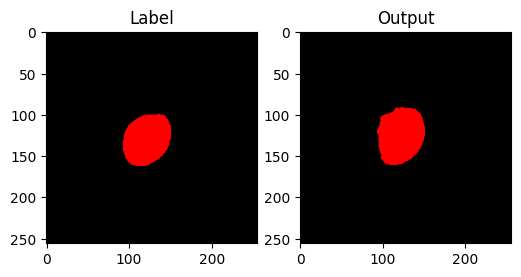

 13%|█▎        | 20/150 [12:05<1:18:19, 36.15s/it]




Epoch [21/150], Loss: 0.2679493043
Save new model


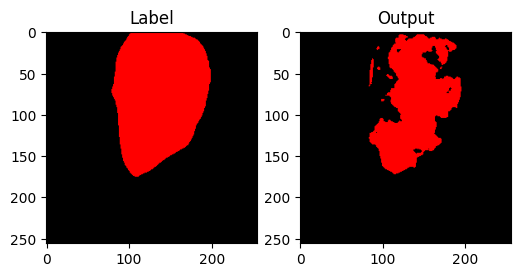

 14%|█▍        | 21/150 [12:42<1:18:00, 36.28s/it]




Epoch [22/150], Loss: 0.2449203191
Save new model


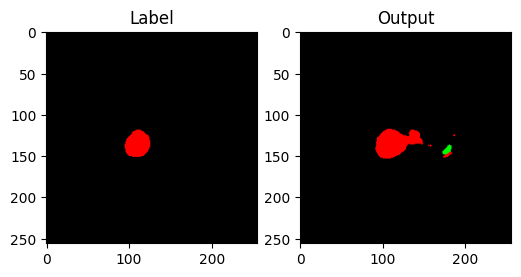

 15%|█▍        | 22/150 [13:19<1:17:35, 36.37s/it]




Epoch [23/150], Loss: 0.2746799416


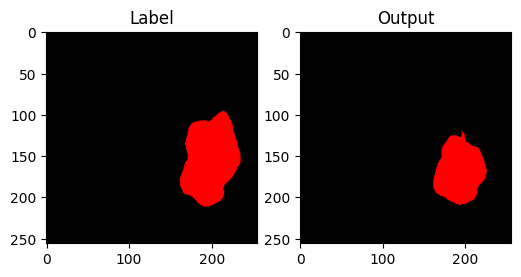

 15%|█▌        | 23/150 [13:54<1:16:17, 36.04s/it]




Epoch [24/150], Loss: 0.2677126745


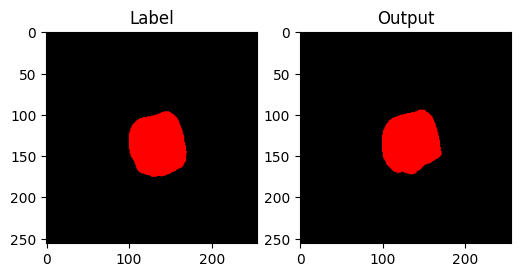

 16%|█▌        | 24/150 [14:29<1:15:10, 35.80s/it]




Epoch [25/150], Loss: 0.2485092775


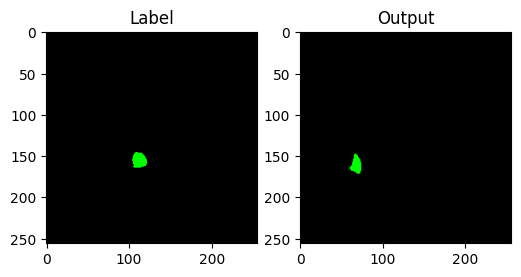

 17%|█▋        | 25/150 [15:04<1:14:13, 35.63s/it]




Epoch [26/150], Loss: 0.2740836178


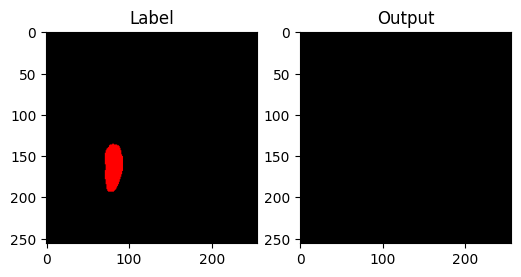

 17%|█▋        | 26/150 [15:40<1:13:22, 35.51s/it]




Epoch [27/150], Loss: 0.2328130626
Save new model


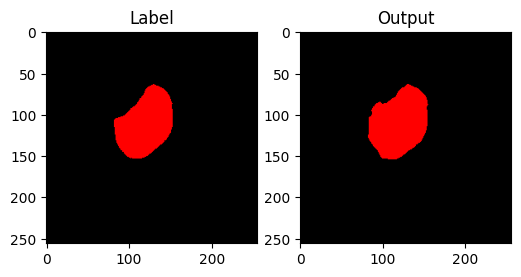

 18%|█▊        | 27/150 [16:16<1:13:33, 35.89s/it]




Epoch [28/150], Loss: 0.2406659080


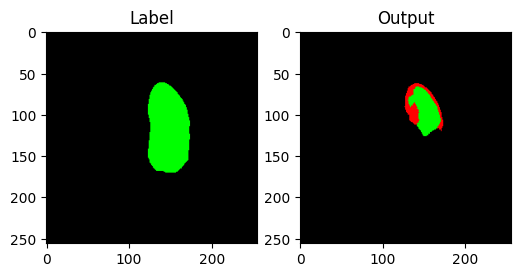

 19%|█▊        | 28/150 [16:52<1:12:35, 35.70s/it]




Epoch [29/150], Loss: 0.2320111864
Save new model


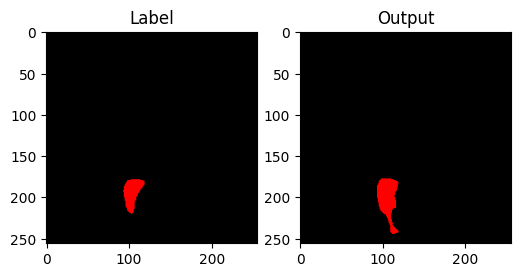

 19%|█▉        | 29/150 [17:28<1:12:33, 35.98s/it]




Epoch [30/150], Loss: 0.2274882427
Save new model


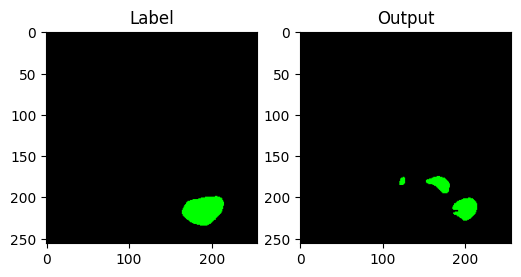

 20%|██        | 30/150 [18:05<1:12:31, 36.26s/it]




Epoch [31/150], Loss: 0.2307364998


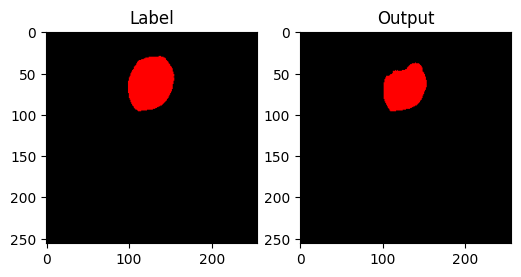

 21%|██        | 31/150 [18:40<1:11:19, 35.96s/it]




Epoch [32/150], Loss: 0.2374401780


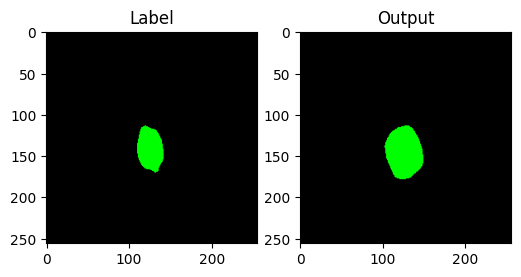

 21%|██▏       | 32/150 [19:16<1:10:18, 35.75s/it]




Epoch [33/150], Loss: 0.2383594513


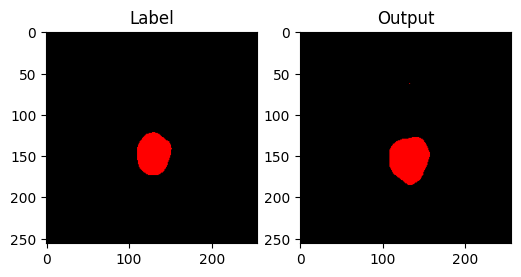

 22%|██▏       | 33/150 [19:51<1:09:25, 35.60s/it]




Epoch [34/150], Loss: 0.2263900729
Save new model


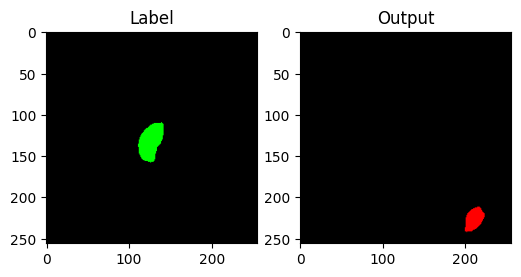

 23%|██▎       | 34/150 [20:27<1:09:17, 35.84s/it]




Epoch [35/150], Loss: 0.2215232872
Save new model


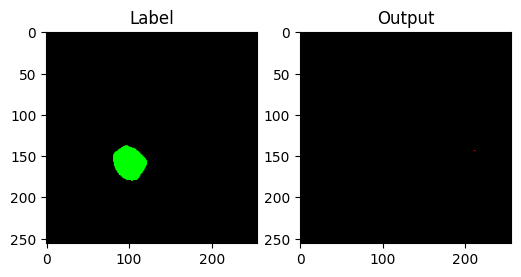

 23%|██▎       | 35/150 [21:04<1:09:01, 36.01s/it]




Epoch [36/150], Loss: 0.2632826842


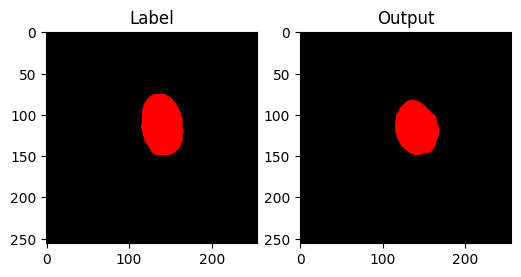

 24%|██▍       | 36/150 [21:39<1:08:04, 35.83s/it]




Epoch [37/150], Loss: 0.2300547476


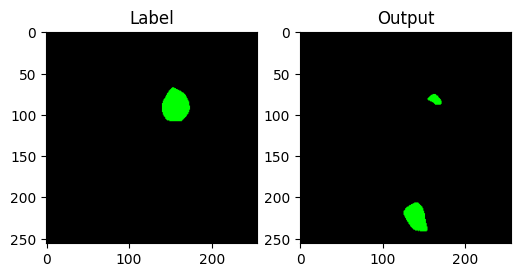

 25%|██▍       | 37/150 [22:14<1:07:08, 35.65s/it]




Epoch [38/150], Loss: 0.2361934724


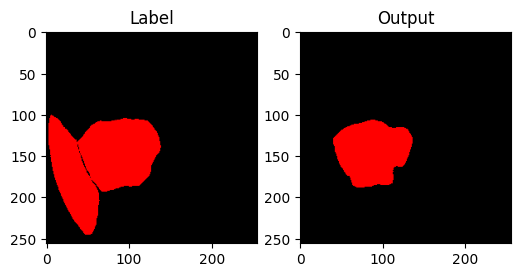

 25%|██▌       | 38/150 [22:50<1:06:18, 35.52s/it]




Epoch [39/150], Loss: 0.2366078679


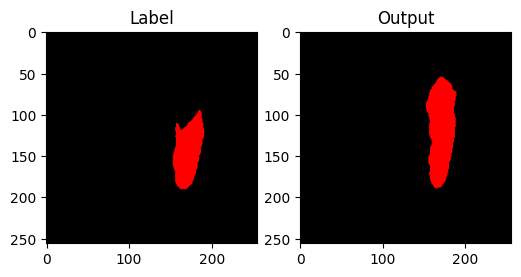

 26%|██▌       | 39/150 [23:25<1:05:33, 35.44s/it]




Epoch [40/150], Loss: 0.2290814404


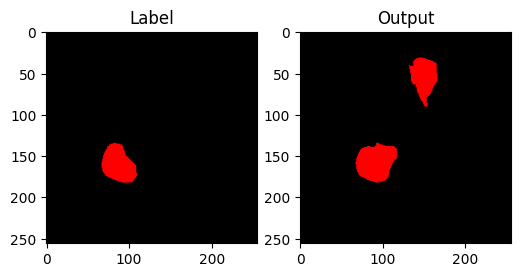

 27%|██▋       | 40/150 [24:00<1:04:51, 35.38s/it]




Epoch [41/150], Loss: 0.2154341122
Save new model


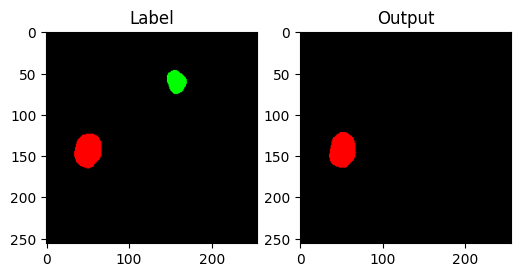

 27%|██▋       | 41/150 [24:36<1:04:46, 35.65s/it]




Epoch [42/150], Loss: 0.2088591709
Save new model


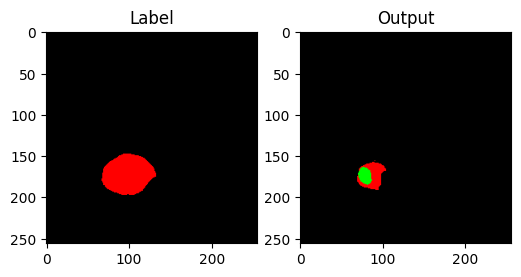

 28%|██▊       | 42/150 [25:13<1:04:34, 35.87s/it]




Epoch [43/150], Loss: 0.2183940239


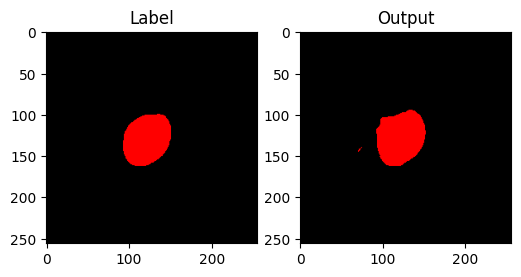

 29%|██▊       | 43/150 [25:48<1:03:37, 35.68s/it]




Epoch [44/150], Loss: 0.2093315973


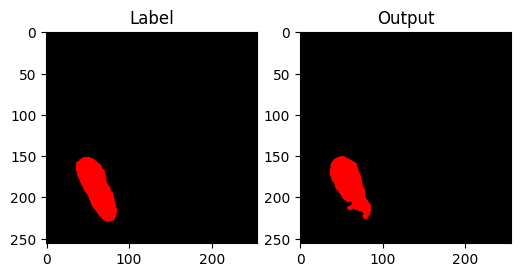

 29%|██▉       | 44/150 [26:23<1:02:47, 35.55s/it]




Epoch [45/150], Loss: 0.1970040764
Save new model


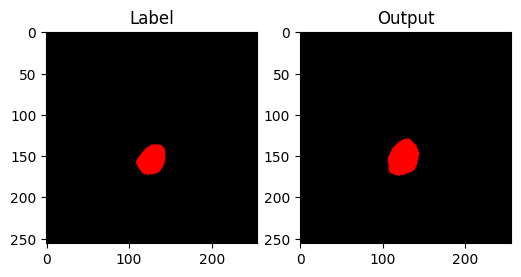

 30%|███       | 45/150 [27:00<1:02:43, 35.85s/it]




Epoch [46/150], Loss: 0.2091339655


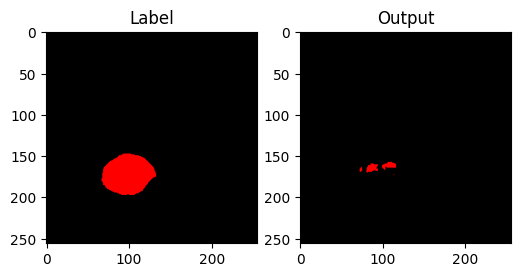

 31%|███       | 46/150 [27:35<1:01:49, 35.66s/it]




Epoch [47/150], Loss: 0.2152201476


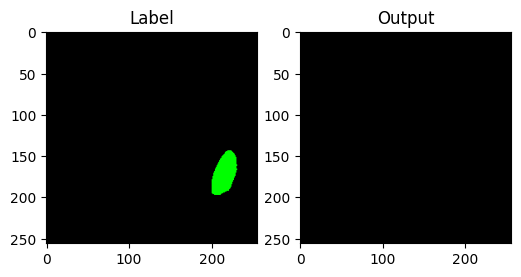

 31%|███▏      | 47/150 [28:10<1:00:59, 35.53s/it]




Epoch [48/150], Loss: 0.2422035589


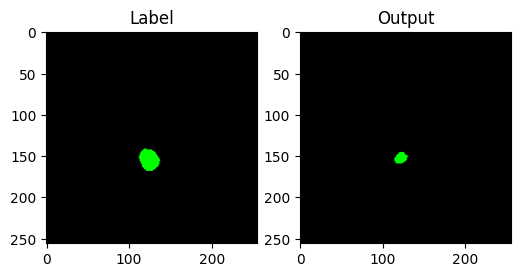

 32%|███▏      | 48/150 [28:45<1:00:13, 35.43s/it]




Epoch [49/150], Loss: 0.1940395402
Save new model


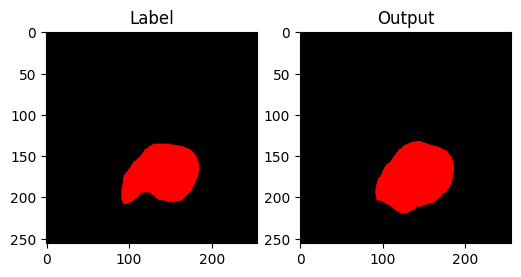

 33%|███▎      | 49/150 [29:22<1:00:07, 35.72s/it]




Epoch [50/150], Loss: 0.2274782577


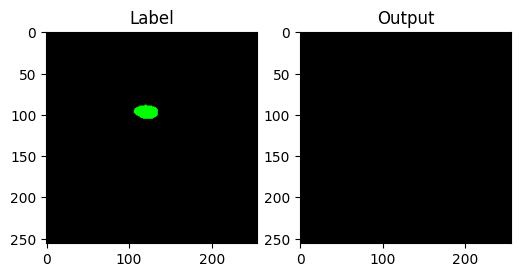

 33%|███▎      | 50/150 [29:57<59:17, 35.58s/it]  




Epoch [51/150], Loss: 0.2068318616


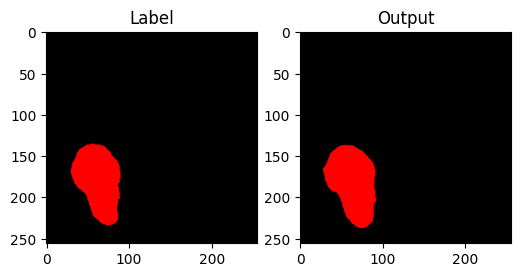

 34%|███▍      | 51/150 [30:32<58:31, 35.47s/it]




Epoch [52/150], Loss: 0.2153490776


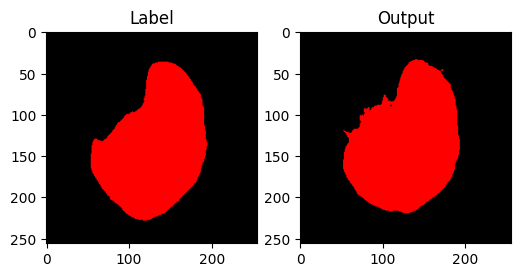

 35%|███▍      | 52/150 [31:07<57:48, 35.39s/it]




Epoch [53/150], Loss: 0.1936018232
Save new model


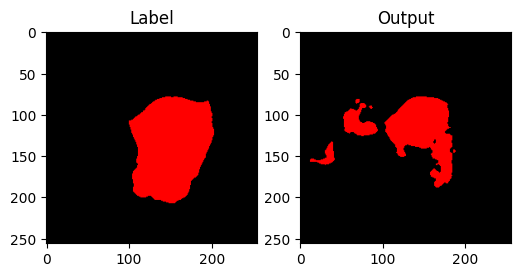

 35%|███▌      | 53/150 [31:44<57:48, 35.76s/it]




Epoch [54/150], Loss: 0.2089519868


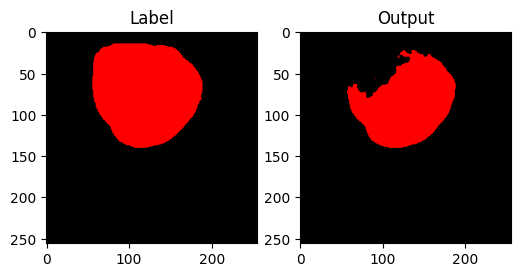

 36%|███▌      | 54/150 [32:19<57:03, 35.66s/it]




Epoch [55/150], Loss: 0.1953235544


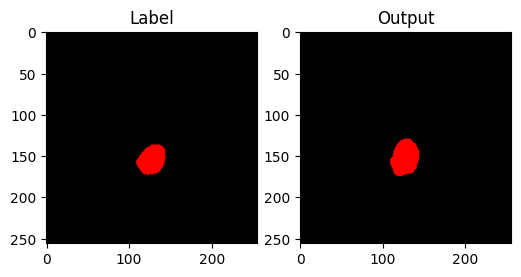

 37%|███▋      | 55/150 [32:55<56:15, 35.54s/it]




Epoch [56/150], Loss: 0.2025807110


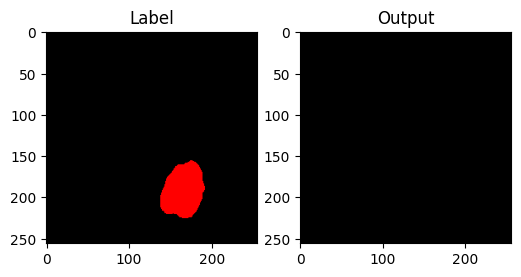

 37%|███▋      | 56/150 [33:30<55:31, 35.45s/it]




Epoch [57/150], Loss: 0.2008291036


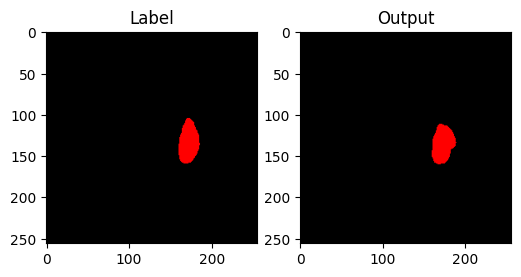

 38%|███▊      | 57/150 [34:05<54:50, 35.38s/it]




Epoch [58/150], Loss: 0.2139733829


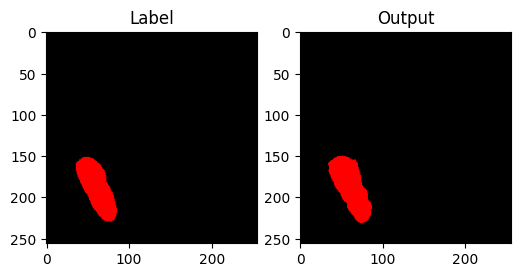

 39%|███▊      | 58/150 [34:40<54:10, 35.34s/it]




Epoch [59/150], Loss: 0.2008933677


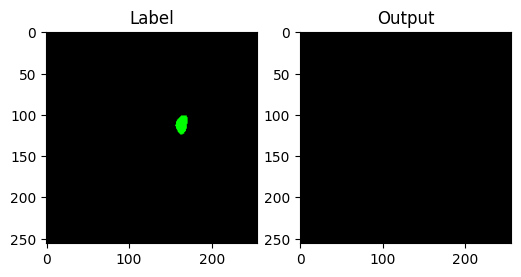

 39%|███▉      | 59/150 [35:16<53:32, 35.31s/it]




Epoch [60/150], Loss: 0.2088168630


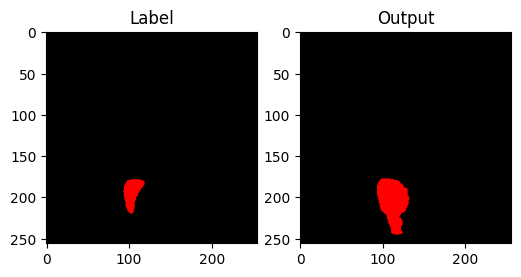

 40%|████      | 60/150 [35:51<52:55, 35.28s/it]




Epoch [61/150], Loss: 0.2091024300


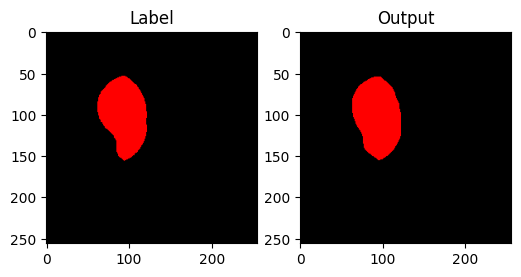

 41%|████      | 61/150 [36:26<52:18, 35.27s/it]




Epoch [62/150], Loss: 0.2007078391


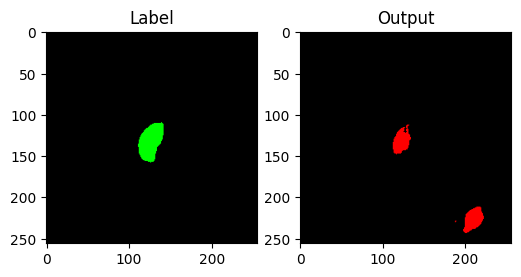

 41%|████▏     | 62/150 [37:02<51:47, 35.31s/it]




Epoch [63/150], Loss: 0.2090312174


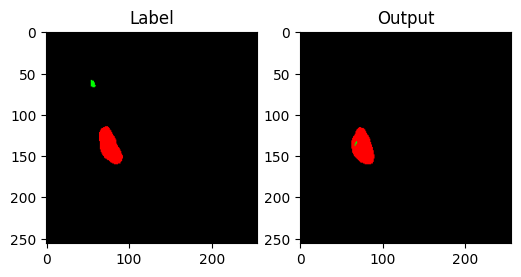

 42%|████▏     | 63/150 [37:37<51:10, 35.29s/it]




Epoch [64/150], Loss: 0.2355260860


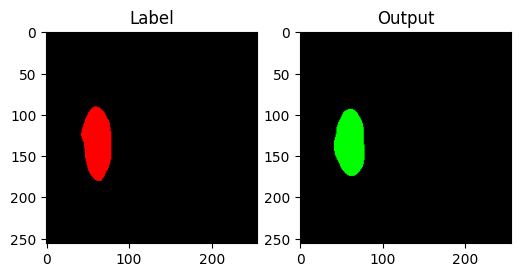

 43%|████▎     | 64/150 [38:12<50:33, 35.27s/it]




Epoch [65/150], Loss: 0.1923493955
Save new model


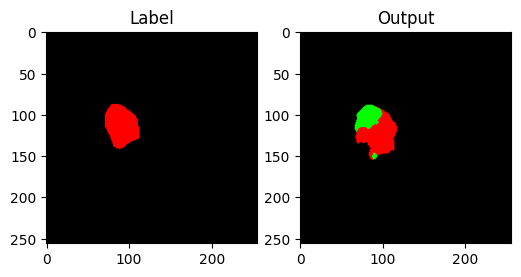

 43%|████▎     | 65/150 [38:49<50:29, 35.64s/it]




Epoch [66/150], Loss: 0.2143866867


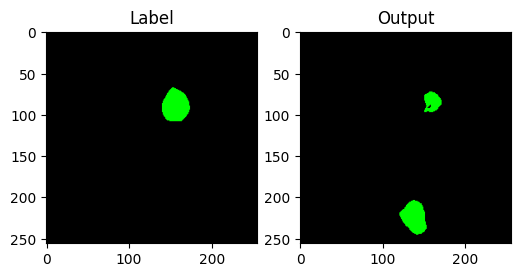

 44%|████▍     | 66/150 [39:24<49:42, 35.51s/it]




Epoch [67/150], Loss: 0.2109379574


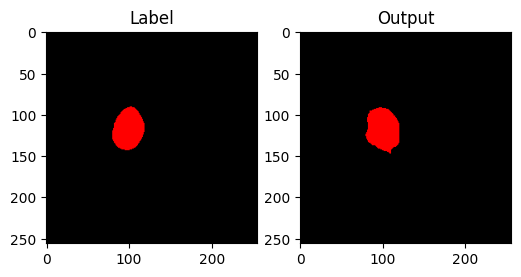

 45%|████▍     | 67/150 [39:59<48:59, 35.42s/it]




Epoch [68/150], Loss: 0.2252600577


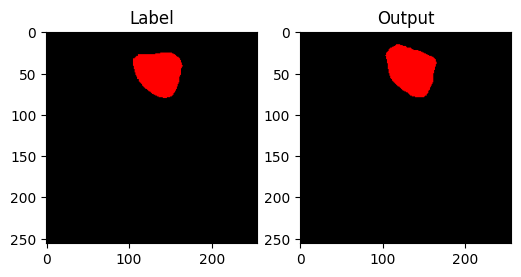

 45%|████▌     | 68/150 [40:34<48:19, 35.36s/it]




Epoch [69/150], Loss: 0.1999540260


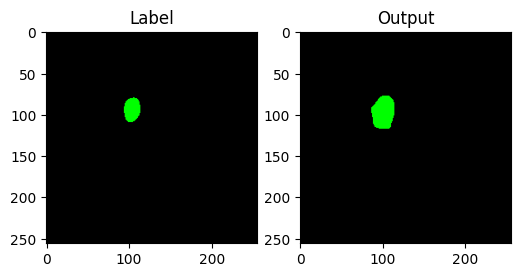

 46%|████▌     | 69/150 [41:09<47:40, 35.31s/it]




Epoch [70/150], Loss: 0.2084416839


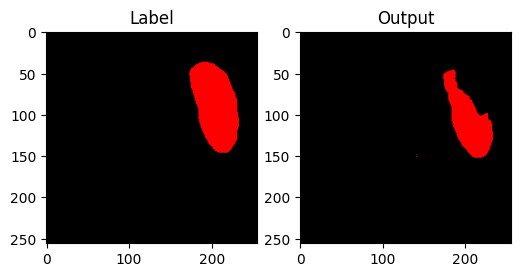

 47%|████▋     | 70/150 [41:45<47:02, 35.28s/it]




Epoch [71/150], Loss: 0.2781861367


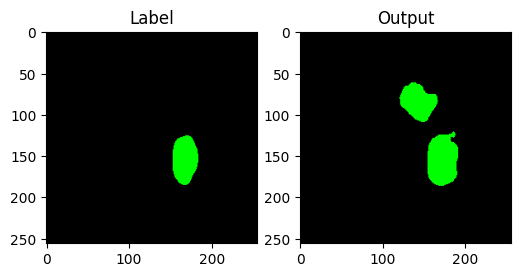

 47%|████▋     | 71/150 [42:20<46:28, 35.30s/it]




Epoch [72/150], Loss: 0.2393230498


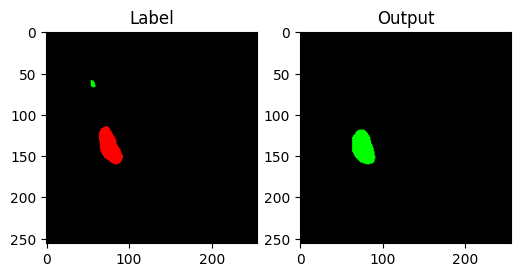

 48%|████▊     | 72/150 [42:55<45:51, 35.28s/it]




Epoch [73/150], Loss: 0.2197668335


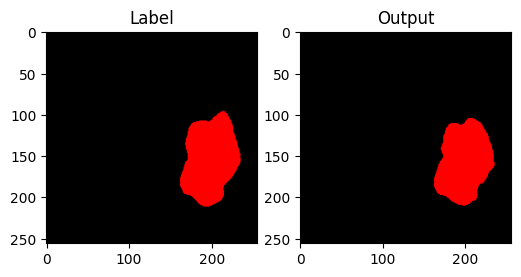

 49%|████▊     | 73/150 [43:30<45:14, 35.26s/it]




Epoch [74/150], Loss: 0.1969259794


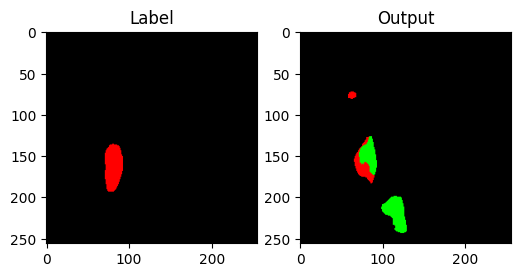

 49%|████▉     | 74/150 [44:06<44:38, 35.24s/it]




Epoch [75/150], Loss: 0.2022757249


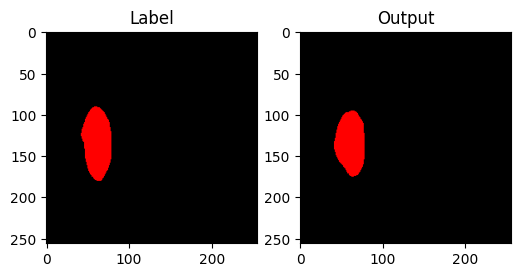

 50%|█████     | 75/150 [44:41<44:02, 35.23s/it]




Epoch [76/150], Loss: 0.2162482681


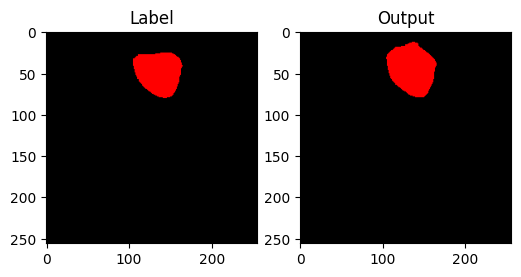

 51%|█████     | 76/150 [45:16<43:26, 35.23s/it]




Epoch [77/150], Loss: 0.2200001381


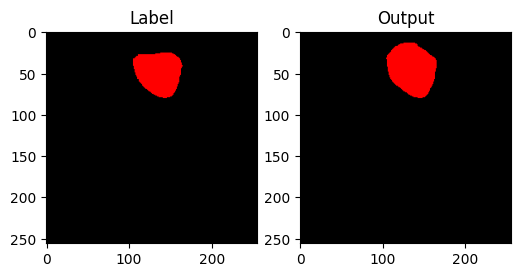

 51%|█████▏    | 77/150 [45:51<42:58, 35.32s/it]




Epoch [78/150], Loss: 0.1844743863
Save new model


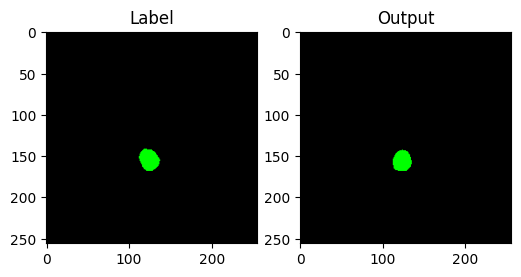

 52%|█████▏    | 78/150 [46:28<42:45, 35.63s/it]




Epoch [79/150], Loss: 0.2096961032


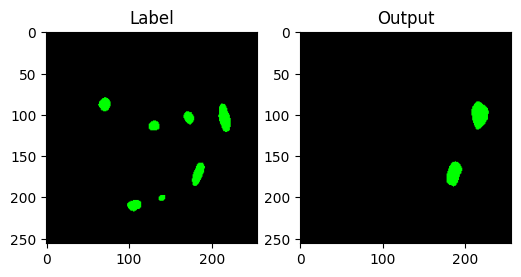

 53%|█████▎    | 79/150 [47:03<42:00, 35.50s/it]




Epoch [80/150], Loss: 0.1940264616


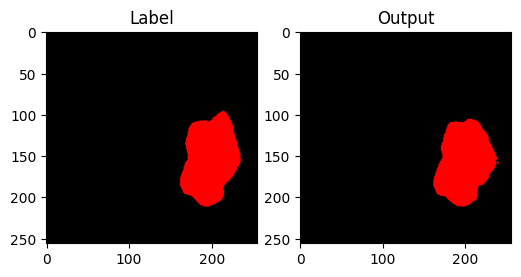

 53%|█████▎    | 80/150 [47:38<41:22, 35.46s/it]




Epoch [81/150], Loss: 0.1970215612


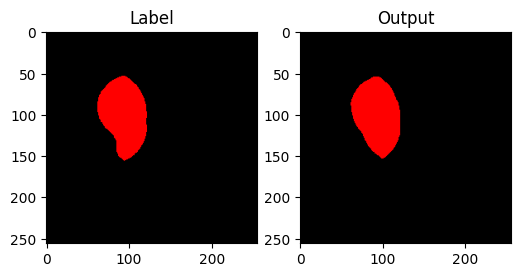

 54%|█████▍    | 81/150 [48:14<40:41, 35.39s/it]




Epoch [82/150], Loss: 0.2333295420


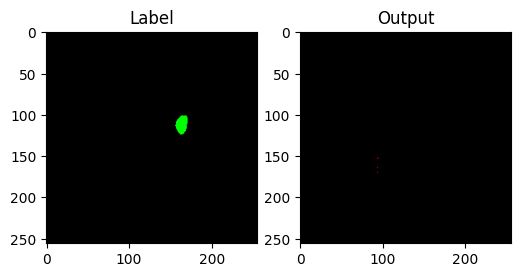

 55%|█████▍    | 82/150 [48:49<40:02, 35.33s/it]




Epoch [83/150], Loss: 0.2371558306


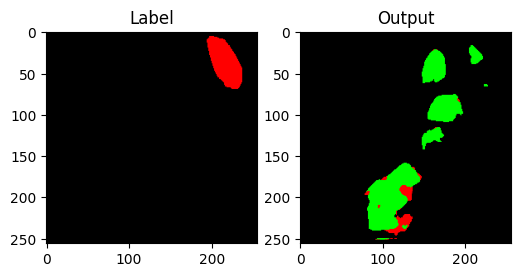

 55%|█████▌    | 83/150 [49:24<39:25, 35.30s/it]




Epoch [84/150], Loss: 0.1992438046


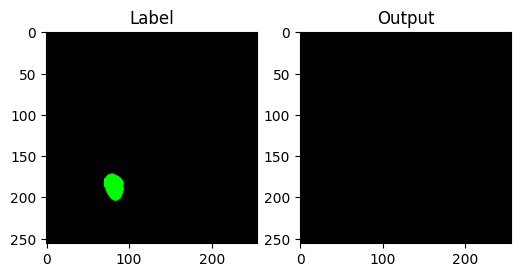

 56%|█████▌    | 84/150 [49:59<38:48, 35.29s/it]




Epoch [85/150], Loss: 0.2090734759


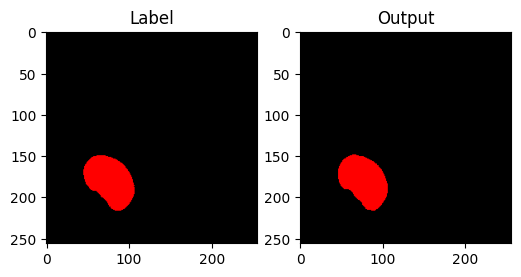

 57%|█████▋    | 85/150 [50:35<38:11, 35.26s/it]




Epoch [86/150], Loss: 0.1873256696


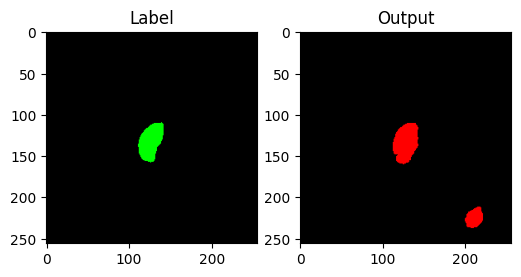

 57%|█████▋    | 86/150 [51:10<37:36, 35.25s/it]




Epoch [87/150], Loss: 0.2393851211


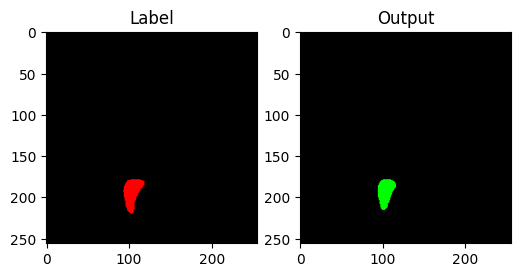

 58%|█████▊    | 87/150 [51:45<36:59, 35.23s/it]




Epoch [88/150], Loss: 0.2104963164


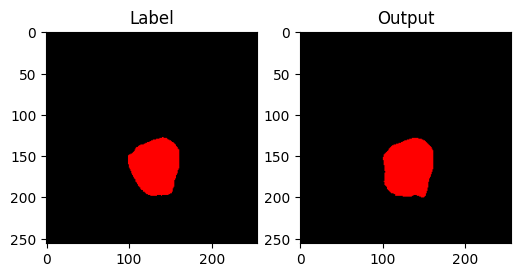

 59%|█████▊    | 88/150 [52:20<36:23, 35.21s/it]




Epoch [89/150], Loss: 0.2461319176


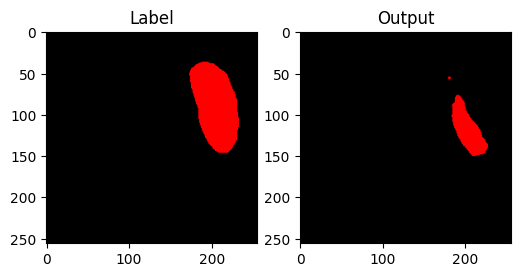

 59%|█████▉    | 89/150 [52:55<35:50, 35.25s/it]




Epoch [90/150], Loss: 0.2036644432


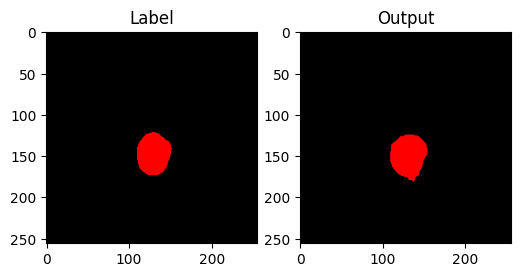

 60%|██████    | 90/150 [53:31<35:13, 35.23s/it]




Epoch [91/150], Loss: 0.2154914267


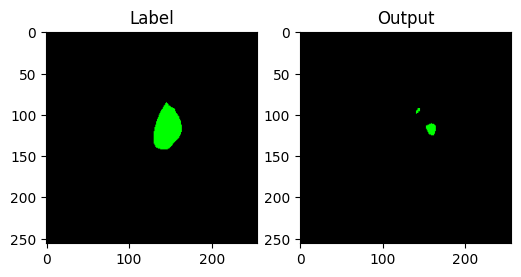

 61%|██████    | 91/150 [54:06<34:37, 35.20s/it]




Epoch [92/150], Loss: 0.1907588255


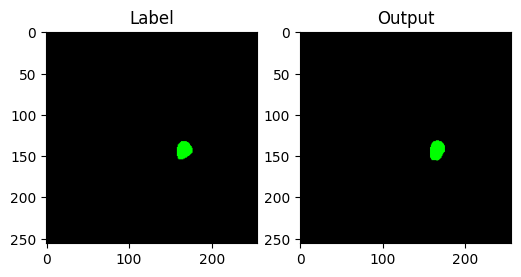

 61%|██████▏   | 92/150 [54:41<34:01, 35.20s/it]




Epoch [93/150], Loss: 0.2329386037


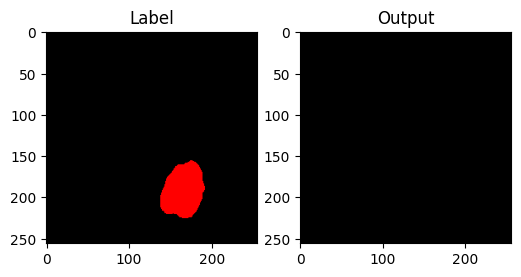

 62%|██████▏   | 93/150 [55:16<33:25, 35.19s/it]




Epoch [94/150], Loss: 0.2058313965


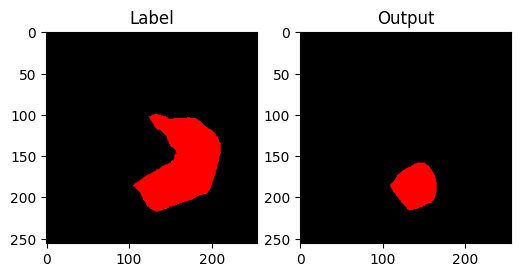

 63%|██████▎   | 94/150 [55:51<32:50, 35.18s/it]




Epoch [95/150], Loss: 0.2001906519


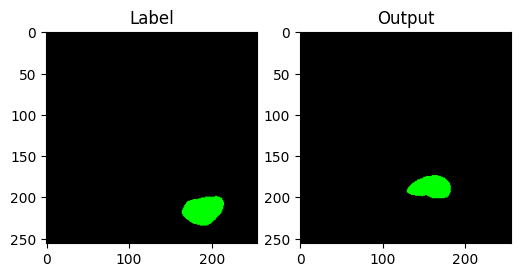

 63%|██████▎   | 95/150 [56:26<32:14, 35.18s/it]




Epoch [96/150], Loss: 0.2060092487


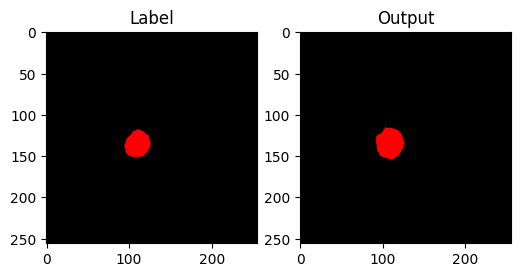

 64%|██████▍   | 96/150 [57:02<31:39, 35.18s/it]




Epoch [97/150], Loss: 0.1994705962


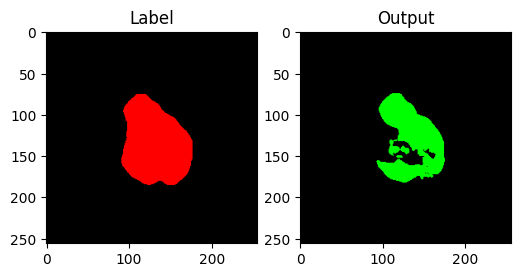

 65%|██████▍   | 97/150 [57:37<31:04, 35.19s/it]




Epoch [98/150], Loss: 0.2188454907


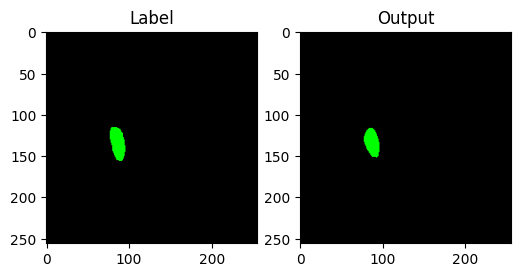

 65%|██████▌   | 98/150 [58:12<30:32, 35.24s/it]




Epoch [99/150], Loss: 0.1852658265


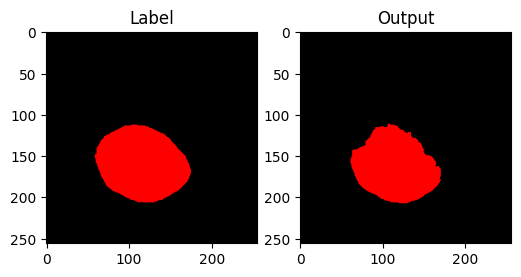

 66%|██████▌   | 99/150 [58:47<29:57, 35.24s/it]




Epoch [100/150], Loss: 0.2182693034


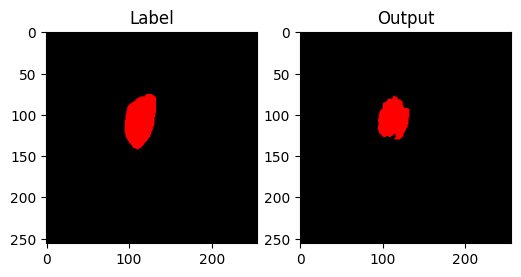

 67%|██████▋   | 100/150 [59:23<29:20, 35.21s/it]




Epoch [101/150], Loss: 0.2116360619


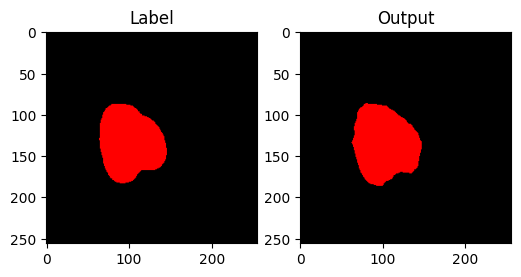

 67%|██████▋   | 101/150 [59:58<28:48, 35.27s/it]




Epoch [102/150], Loss: 0.2131101392


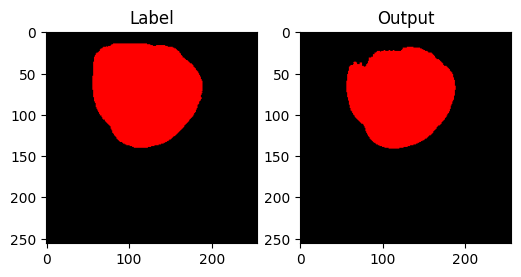

 68%|██████▊   | 102/150 [1:00:33<28:12, 35.25s/it]




Epoch [103/150], Loss: 0.1840583361
Save new model


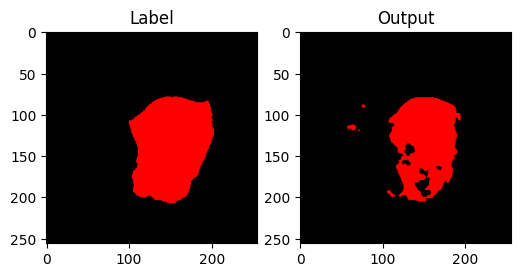

 69%|██████▊   | 103/150 [1:01:10<27:53, 35.60s/it]




Epoch [104/150], Loss: 0.2483849116


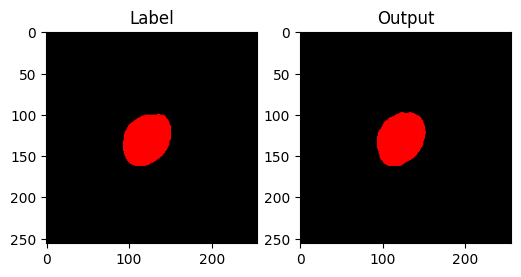

 69%|██████▉   | 104/150 [1:01:45<27:12, 35.48s/it]




Epoch [105/150], Loss: 0.2609587438


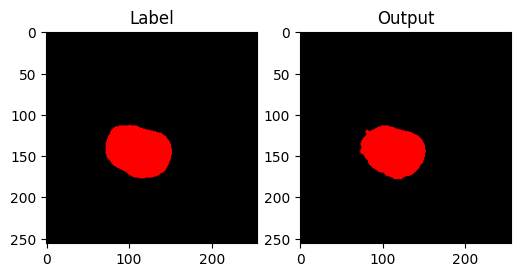

 70%|███████   | 105/150 [1:02:20<26:31, 35.38s/it]




Epoch [106/150], Loss: 0.2020155426


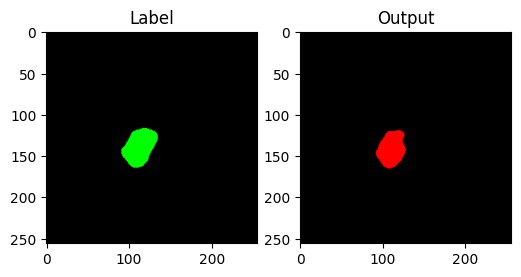

 71%|███████   | 106/150 [1:02:55<25:53, 35.30s/it]




Epoch [107/150], Loss: 0.2093564541


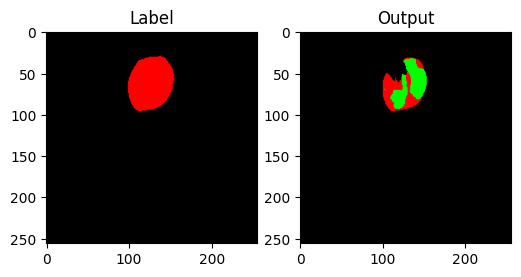

 71%|███████▏  | 107/150 [1:03:30<25:17, 35.30s/it]




Epoch [108/150], Loss: 0.2131898375


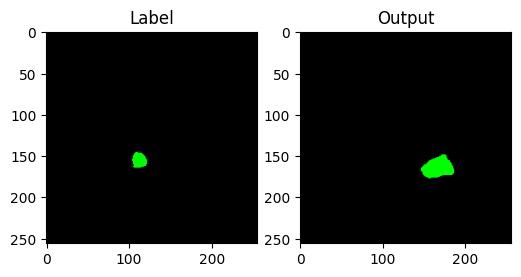

 72%|███████▏  | 108/150 [1:04:05<24:40, 35.24s/it]




Epoch [109/150], Loss: 0.1948649121


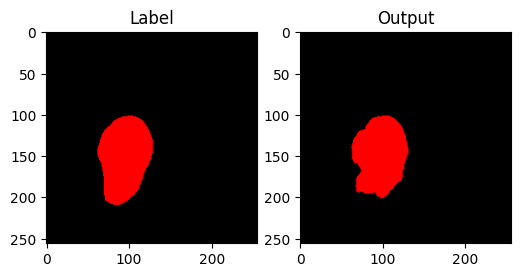

 73%|███████▎  | 109/150 [1:04:41<24:03, 35.20s/it]




Epoch [110/150], Loss: 0.1854250196


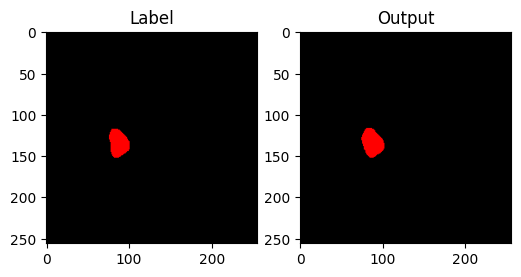

 73%|███████▎  | 110/150 [1:05:16<23:27, 35.18s/it]




Epoch [111/150], Loss: 0.2060679945


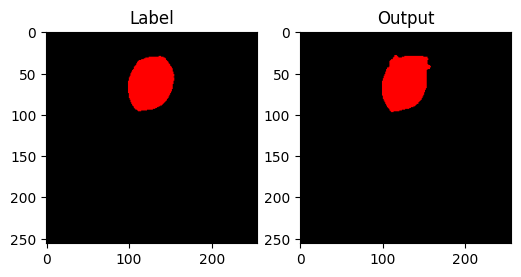

 74%|███████▍  | 111/150 [1:05:51<22:51, 35.17s/it]




Epoch [112/150], Loss: 0.2301125899


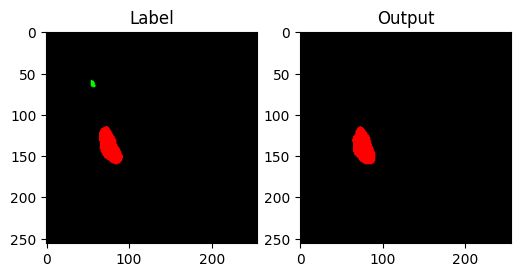

 75%|███████▍  | 112/150 [1:06:26<22:16, 35.16s/it]




Epoch [113/150], Loss: 0.1987460657


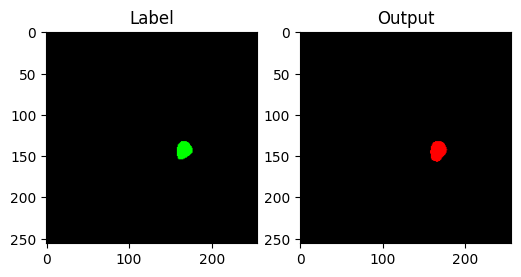

 75%|███████▌  | 113/150 [1:07:01<21:40, 35.15s/it]




Epoch [114/150], Loss: 0.1966132585


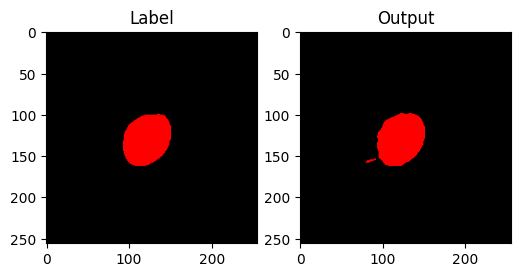

 76%|███████▌  | 114/150 [1:07:36<21:04, 35.13s/it]




Epoch [115/150], Loss: 0.2091281546


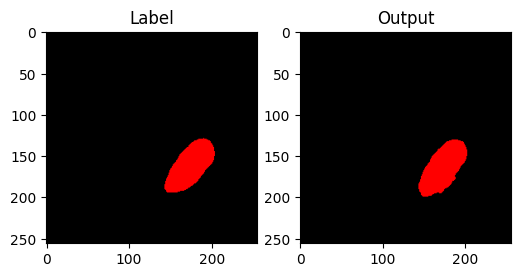

 77%|███████▋  | 115/150 [1:08:11<20:29, 35.13s/it]




Epoch [116/150], Loss: 0.1874203155


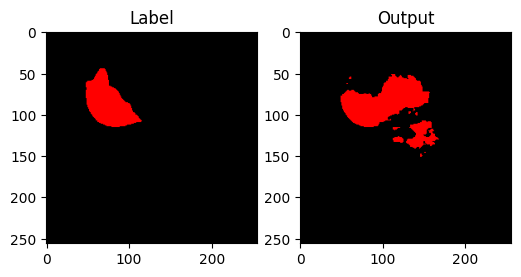

 77%|███████▋  | 116/150 [1:08:47<19:56, 35.20s/it]




Epoch [117/150], Loss: 0.1859083330


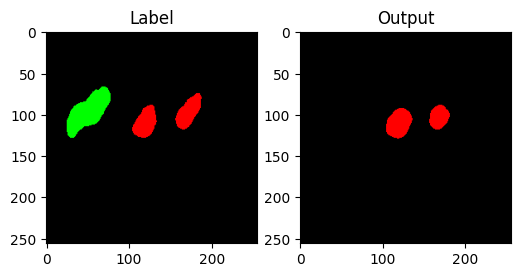

 78%|███████▊  | 117/150 [1:09:22<19:20, 35.17s/it]




Epoch [118/150], Loss: 0.1967122543


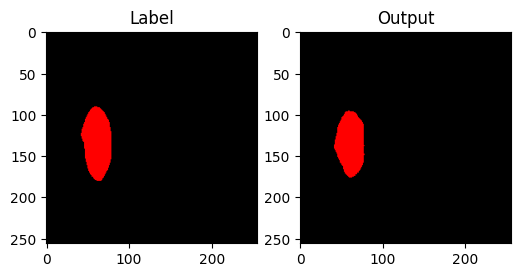

 79%|███████▊  | 118/150 [1:09:57<18:44, 35.15s/it]




Epoch [119/150], Loss: 0.1916429481


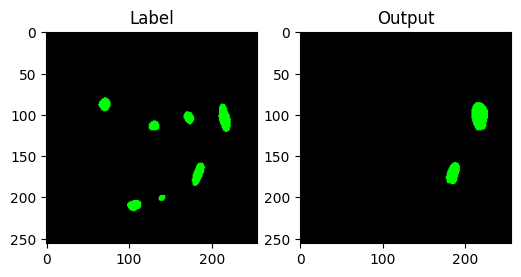

 79%|███████▉  | 119/150 [1:10:32<18:09, 35.15s/it]




Epoch [120/150], Loss: 0.1944009604


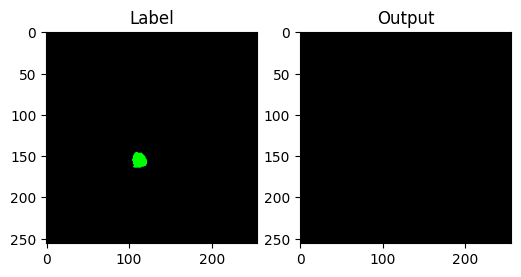

 80%|████████  | 120/150 [1:11:07<17:34, 35.14s/it]




Epoch [121/150], Loss: 0.1885865600


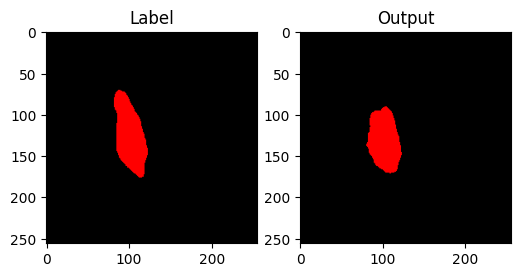

 81%|████████  | 121/150 [1:11:42<16:58, 35.13s/it]




Epoch [122/150], Loss: 0.2007771707


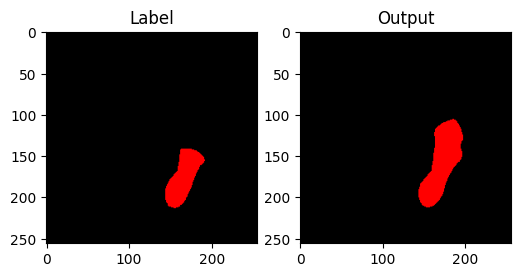

 81%|████████▏ | 122/150 [1:12:17<16:23, 35.13s/it]




Epoch [123/150], Loss: 0.2200081182


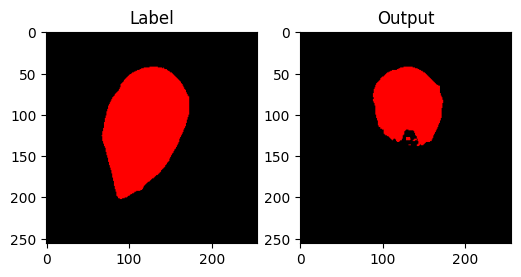

 82%|████████▏ | 123/150 [1:12:52<15:48, 35.12s/it]




Epoch [124/150], Loss: 0.2044937204


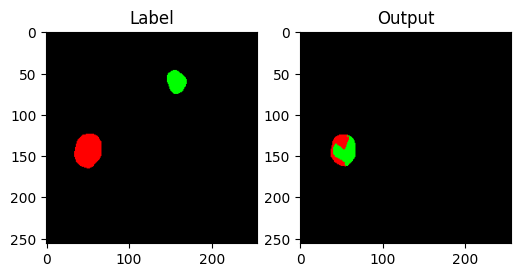

 83%|████████▎ | 124/150 [1:13:28<15:14, 35.17s/it]




Epoch [125/150], Loss: 0.2170625575


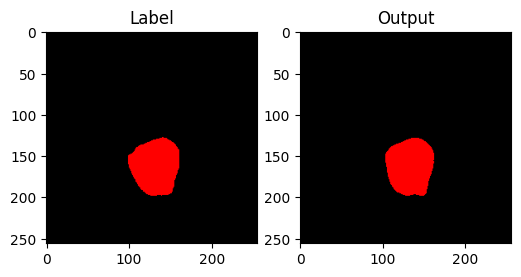

 83%|████████▎ | 125/150 [1:14:03<14:39, 35.17s/it]




Epoch [126/150], Loss: 0.2036873538


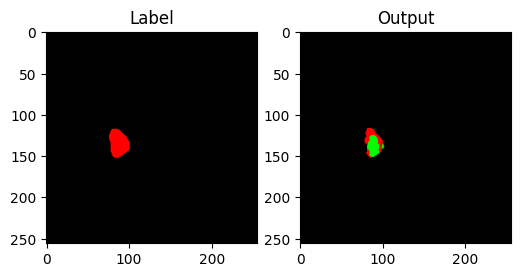

 84%|████████▍ | 126/150 [1:14:38<14:05, 35.24s/it]




Epoch [127/150], Loss: 0.2038078566


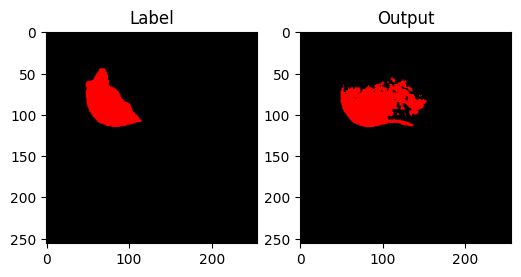

 85%|████████▍ | 127/150 [1:15:13<13:29, 35.21s/it]




Epoch [128/150], Loss: 0.2037446040


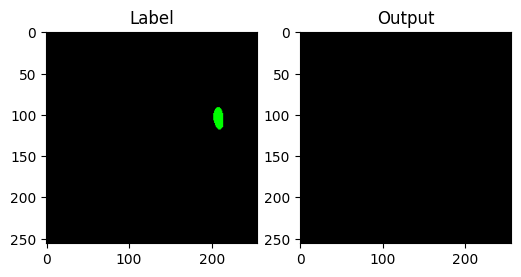

 85%|████████▌ | 128/150 [1:15:49<12:54, 35.18s/it]




Epoch [129/150], Loss: 0.1873924480


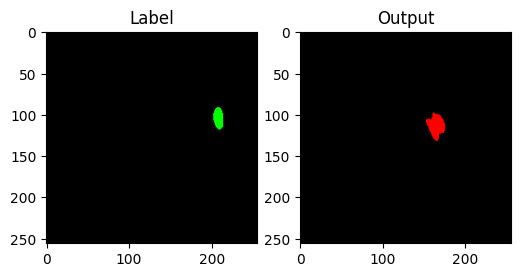

 86%|████████▌ | 129/150 [1:16:24<12:18, 35.17s/it]




Epoch [130/150], Loss: 0.2045987013


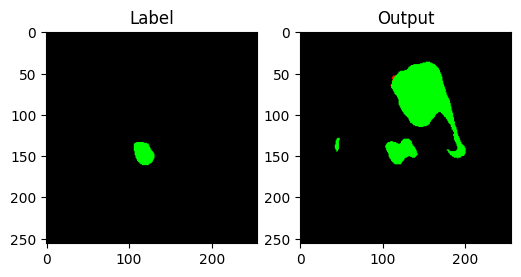

 87%|████████▋ | 130/150 [1:16:59<11:43, 35.16s/it]




Epoch [131/150], Loss: 0.1874029957


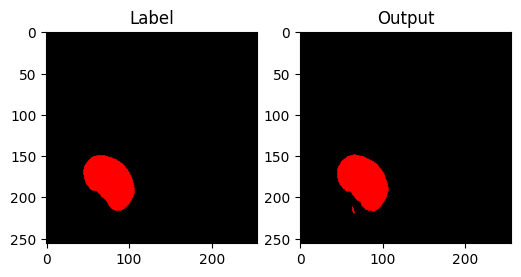

 87%|████████▋ | 131/150 [1:17:34<11:08, 35.17s/it]




Epoch [132/150], Loss: 0.2012860597


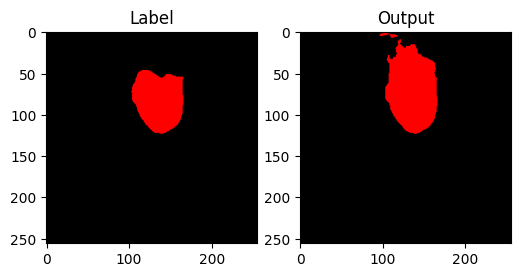

 88%|████████▊ | 132/150 [1:18:09<10:33, 35.19s/it]




Epoch [133/150], Loss: 0.2174784320


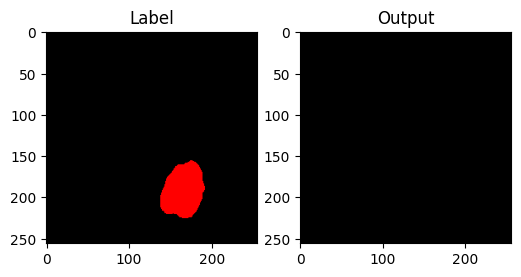

 89%|████████▊ | 133/150 [1:18:45<09:58, 35.23s/it]




Epoch [134/150], Loss: 0.1929614415


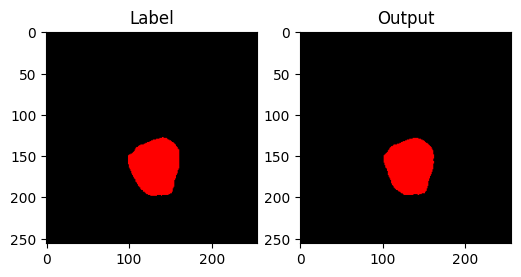

 89%|████████▉ | 134/150 [1:19:20<09:23, 35.22s/it]




Epoch [135/150], Loss: 0.2041586471


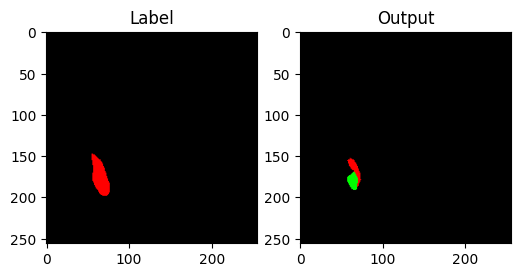

 90%|█████████ | 135/150 [1:19:55<08:47, 35.18s/it]




Epoch [136/150], Loss: 0.2097931940


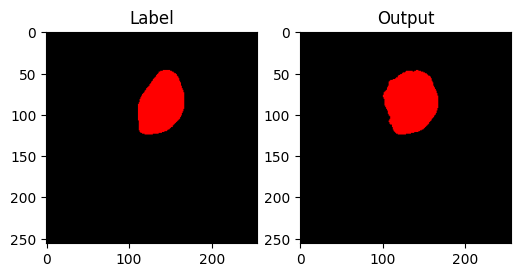

 91%|█████████ | 136/150 [1:20:30<08:12, 35.17s/it]




Epoch [137/150], Loss: 0.2022930326


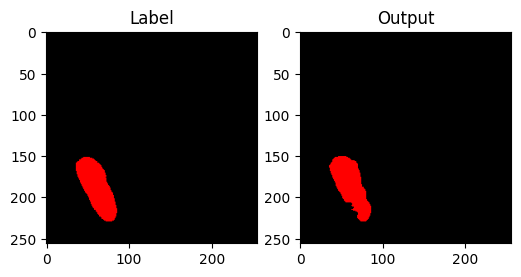

 91%|█████████▏| 137/150 [1:21:05<07:37, 35.18s/it]




Epoch [138/150], Loss: 0.1956808819


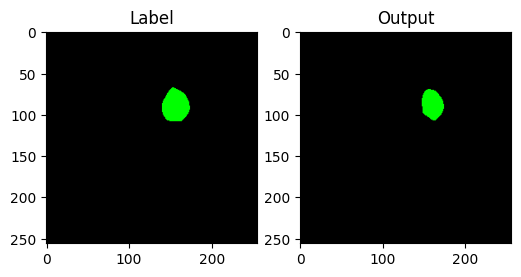

 92%|█████████▏| 138/150 [1:21:40<07:02, 35.18s/it]




Epoch [139/150], Loss: 0.2131550450


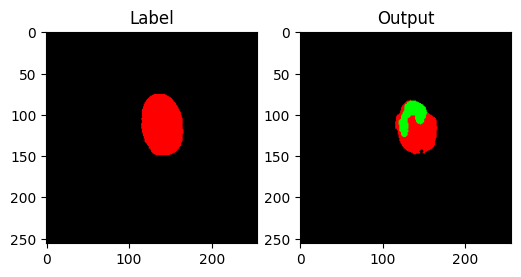

 93%|█████████▎| 139/150 [1:22:16<06:26, 35.17s/it]




Epoch [140/150], Loss: 0.1814069977
Save new model


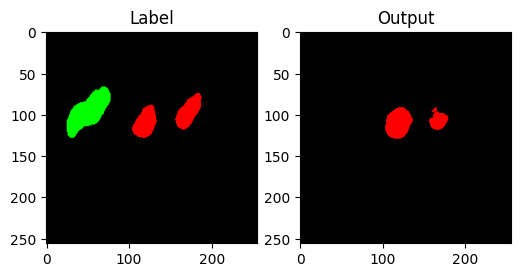

 93%|█████████▎| 140/150 [1:22:52<05:55, 35.56s/it]




Epoch [141/150], Loss: 0.1973031415


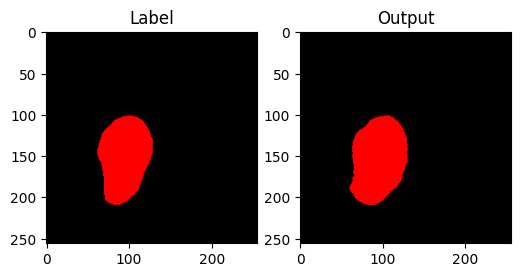

 94%|█████████▍| 141/150 [1:23:27<05:19, 35.45s/it]




Epoch [142/150], Loss: 0.2000800096


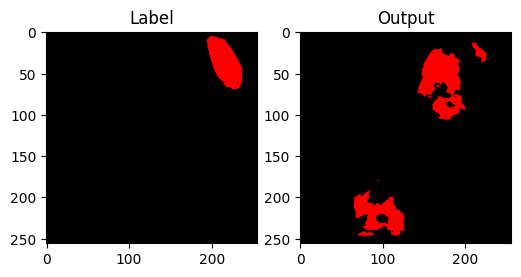

 95%|█████████▍| 142/150 [1:24:03<04:43, 35.41s/it]




Epoch [143/150], Loss: 0.2080238175


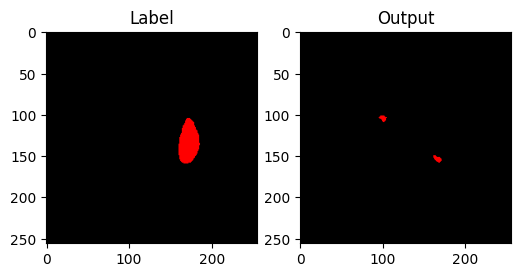

 95%|█████████▌| 143/150 [1:24:38<04:07, 35.34s/it]




Epoch [144/150], Loss: 0.2115851142


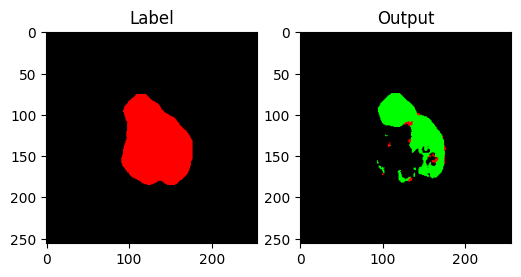

 96%|█████████▌| 144/150 [1:25:13<03:31, 35.29s/it]




Epoch [145/150], Loss: 0.1958947761


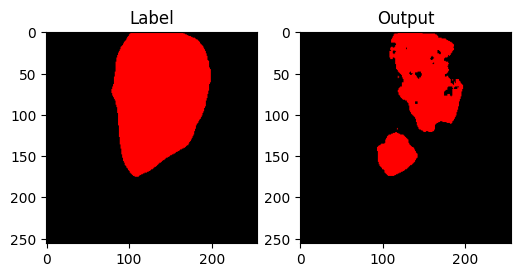

 97%|█████████▋| 145/150 [1:25:48<02:56, 35.26s/it]




Epoch [146/150], Loss: 0.2082233108


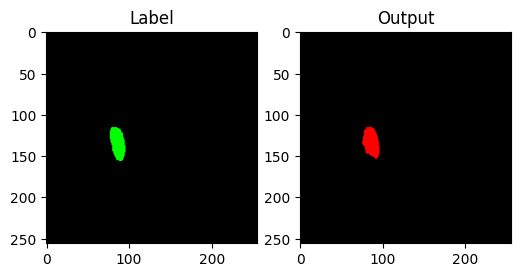

 97%|█████████▋| 146/150 [1:26:23<02:20, 35.24s/it]




Epoch [147/150], Loss: 0.2436304167


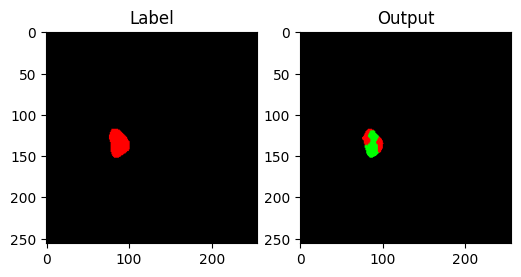

 98%|█████████▊| 147/150 [1:26:58<01:45, 35.22s/it]




Epoch [148/150], Loss: 0.2059106328


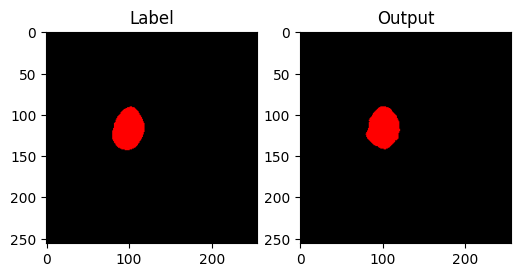

 99%|█████████▊| 148/150 [1:27:34<01:10, 35.21s/it]




Epoch [149/150], Loss: 0.2011610029


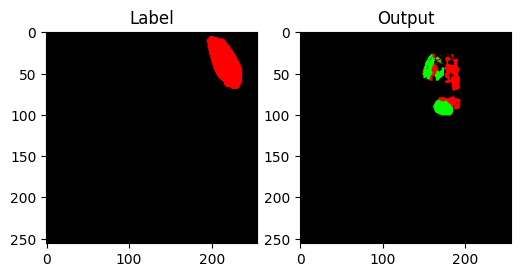

 99%|█████████▉| 149/150 [1:28:09<00:35, 35.20s/it]




Epoch [150/150], Loss: 0.1946516324


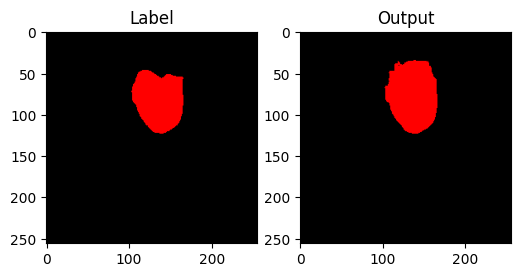

100%|██████████| 150/150 [1:28:44<00:00, 35.50s/it]

In [27]:
best_val_loss = 999

for epoch in tqdm.trange(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()

            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {val_loss/len(val_loader):.10f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = CHECKPOINT_PATH
        torch.save(checkpoint, save_path)
        print('Save new model')

    wandb.log({'Val_loss': val_loss/len(val_loader),
               'Train_loss': train_loss/len(train_loader)
              })

    # scheduler.step(val_loss)

    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()
    print("\n\n")


# Test

In [28]:
checkpoint = torch.load(CHECKPOINT_PATH)
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

/tmp/ipykernel_30/3249193802.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH)


ResNetUNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel

In [29]:
!mkdir prediction

In [30]:
trainsize = 256
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb) 

In [31]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')

/kaggle/working/prediction/6f67b5df7cdf3f33c3ca4d5060a633a8.jpeg
/kaggle/working/prediction/dd78294679c9cbb2a365b5574868eb60.jpeg
/kaggle/working/prediction/5a51625559c7e610b1531871f2fd85a0.jpeg
/kaggle/working/prediction/4e8bfb905b78a91391adc0bb223c4eaf.jpeg
/kaggle/working/prediction/780fd497e1c0e9082ea2c193ac8d551c.jpeg
/kaggle/working/prediction/eb1ef57af2ed9fbb63b28163a745959c.jpeg
/kaggle/working/prediction/cdf3f33c3ca4d5060a633a8d5b2b2b55.jpeg
/kaggle/working/prediction/bec33b5e3d68f9d4c331587f9b9d49e2.jpeg
/kaggle/working/prediction/625559c7e610b1531871f2fd85a04fae.jpeg
/kaggle/working/prediction/05734fbeedd0f9da760db74a29abdb04.jpeg
/kaggle/working/prediction/15fc656702fa602bb3c7abacdbd7e6af.jpeg
/kaggle/working/prediction/dc70626ab4ec3d46e602b296cc5cfd26.jpeg
/kaggle/working/prediction/6240619ebebe9e9c9d00a4262b4fe4a5.jpeg
/kaggle/working/prediction/936de314f2d95e6c487ffa651b477422.jpeg
/kaggle/working/prediction/998906d3694abb47953b0e4909384b57.jpeg
/kaggle/working/predictio